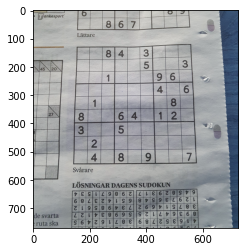

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
import hough


image_path = Path(os.path.abspath('')).joinpath("example.png")
assert image_path.is_file()
img = cv2.imread(str(image_path))
plt.imshow(img)

-1

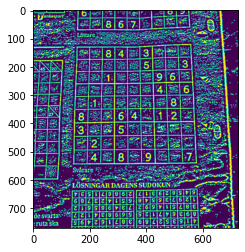

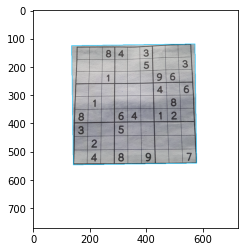

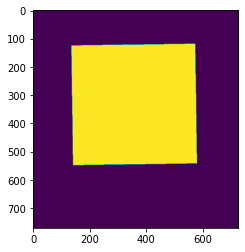

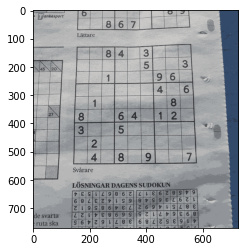

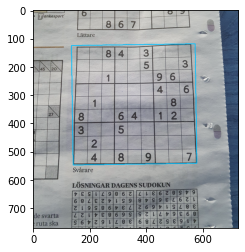

In [2]:
import cv2
import numpy as np

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = image.reshape((w*h, 3)).astype(np.float32)

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
img2 = img.copy()
kmeans = kmeans_color_quantization(img2, clusters=8)

# Convert to grayscale, Gaussian blur, adaptive threshold
gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,2)

# Draw largest enclosing rectangle onto a mask
mask = np.zeros(img2.shape[:2], dtype=np.uint8)
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img2,[box],0, color=(0,191,255), thickness=2)
    cv2.drawContours(mask,[box],0, color=255, thickness=-1)
    break

# Bitwise-and for result
result = cv2.bitwise_and(img2, img2, mask=mask)
result[mask==0] = (255,255,255)

plt.figure()
plt.imshow(thresh)
plt.figure()
plt.imshow(result)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(kmeans)
plt.figure()
plt.imshow(img2)
cv2.waitKey()

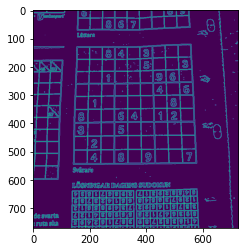

In [3]:
img_canny = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 150, 200)
plt.imshow(img_canny)

In [4]:
accum = hough.houghaccum(img_canny)

Start
Accumulating
done


Text(0.5, 0, 'Offset [px]')

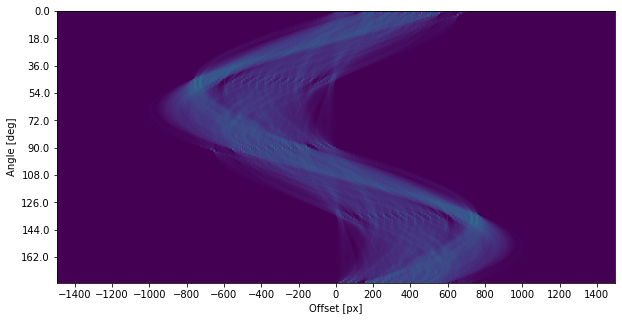

In [5]:
import scipy.ndimage

fig = plt.figure()
fig.set_size_inches(10, 5)
local_maxes = scipy.ndimage.maximum_filter(accum, size=5)
accum_nonzero = accum.copy()
accum_nonzero[accum == 0] = 1
y, x = accum.shape
plt.imshow(accum, extent=[-x/2, x/2, 180-1, 0])  #, norm=LogNorm(vmin=1, vmax=1e2))
ax = plt.gca()
ax.set_aspect(aspect="auto")
h, w = accum.shape
xs = np.arange(0, w, w/5)
ys = np.arange(0, h, h/10)
ax.set_yticks(ys, [str(y / 1) for y in ys])
ax.locator_params(nbins=20)
ax.set_ylabel("Angle [deg]")
ax.set_xlabel("Offset [px]")

(array([0.69154165, 0.69575523, 0.70156144, 0.70589567, 0.70970275,
        0.71319055, 0.71662082, 0.72000653, 0.72382289, 0.7276708 ,
        0.73127183, 0.73468725, 0.7380674 , 0.74114498, 0.74430238,
        0.74718507, 0.74993782, 0.75237687, 0.75478808, 0.75683176,
        0.75900537, 0.76087643, 0.76283101, 0.76469464, 0.76640791,
        0.76801724, 0.76978063, 0.77153846, 0.77320904, 0.77498357,
        0.77675439, 0.77851778, 0.78040369, 0.78228588, 0.78434626,
        0.78638066, 0.78858769, 0.79083555, 0.79336556, 0.79580275,
        0.79816756, 0.80068642, 0.80327768, 0.80603229, 0.80868109,
        0.81178281, 0.81493279, 0.81824797, 0.8217896 , 0.82539621,
        0.82924597, 0.83306975, 0.83697149, 0.84109598, 0.8453207 ,
        0.84971433, 0.85439753, 0.85879117, 0.86307528, 0.86737982,
        0.87131683, 0.87553041, 0.87948598, 0.8834267 , 0.8872579 ,
        0.89124132, 0.89475882, 0.8981167 , 0.90156552, 0.90487328,
        0.90798427, 0.910789  , 0.91365869, 0.91

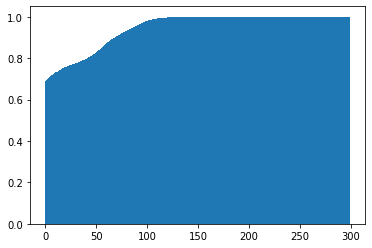

In [6]:
plt.hist(accum.flatten(), bins=range(0, 300), cumulative=True, density=True)

[  1  45  91 135]


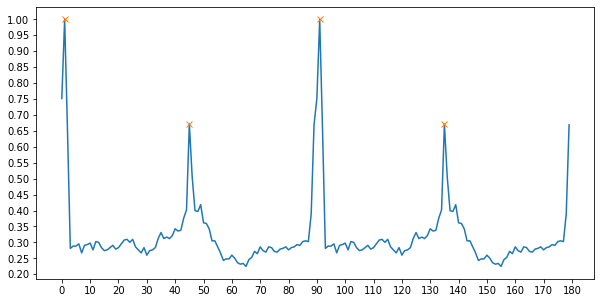

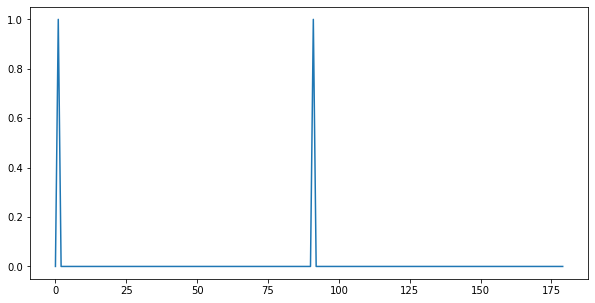

In [7]:
import scipy.signal

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.locator_params(nbins=20)
ys1 = np.amax(accum, axis=1)
angles = np.arange(180)
peaks, _ = scipy.signal.find_peaks(ys1, distance=30, prominence=10, width=(None, 5))
print(peaks)
plt.plot(ys1 / np.amax(ys1))
plt.plot(peaks, ys1[peaks] / np.amax(ys1), 'x')
fig = plt.figure()
fig.set_size_inches(10, 5)
thresh = np.amax(accum.flatten()) * 0.8
accum2 = accum.copy()
accum2[accum < thresh] = 0
ys2 = np.sum(accum2, axis=1)
plt.plot(ys2 / np.amax(ys2))

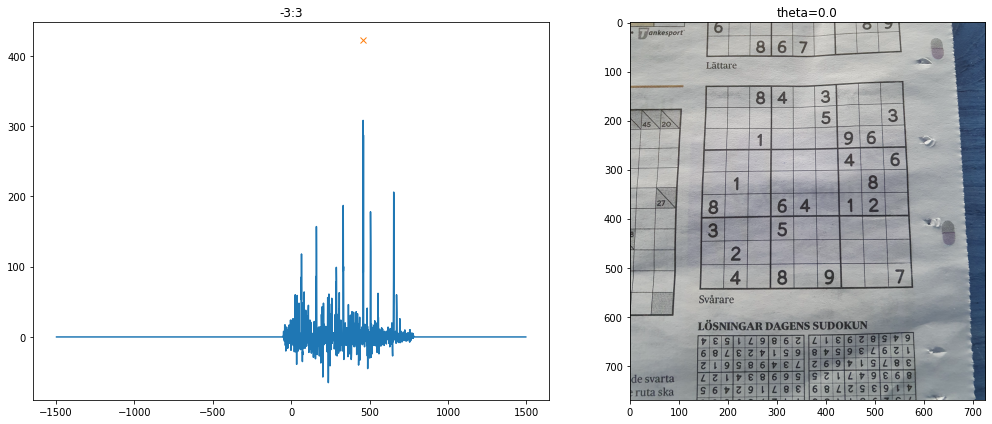

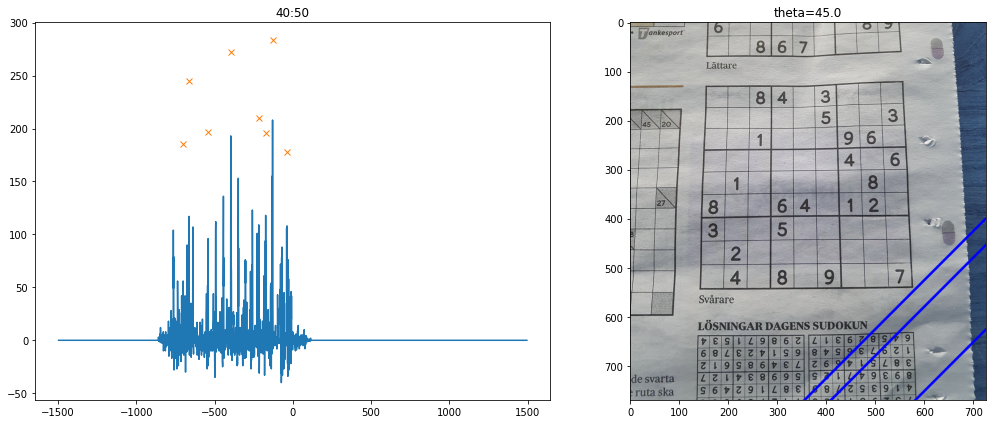

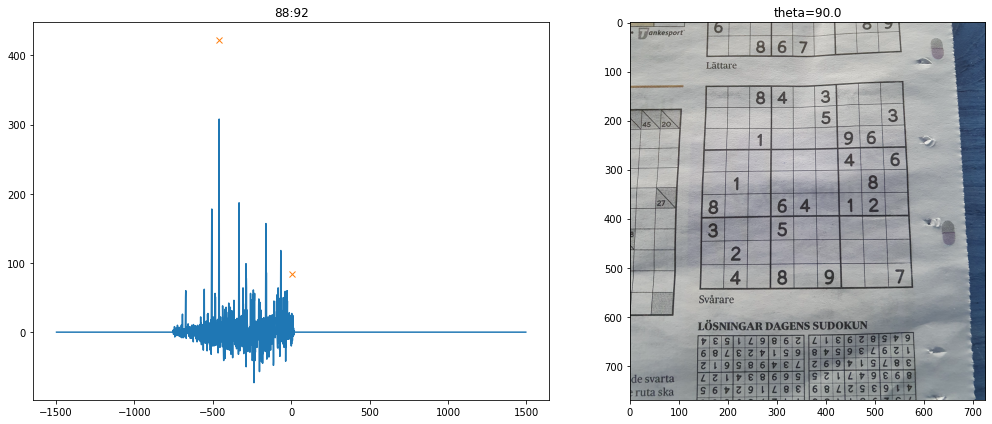

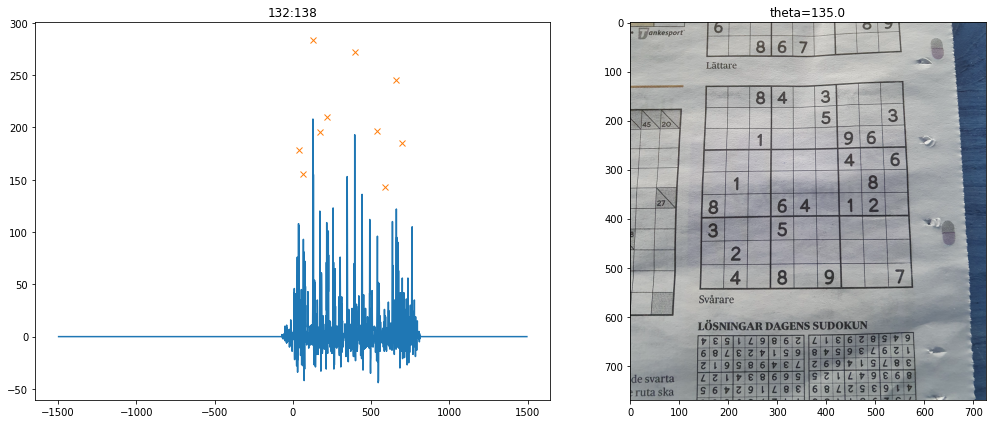

In [8]:
import scipy.signal
import math

rows, cols = accum.shape
tops = ((0, 3), (45, 5), (90, 2), (135, 3))
for mid, width in tops:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    a = mid - width
    b = mid + width
    if a < 0:
        acc = np.vstack((accum[a:], accum[0:b]))
    elif b > rows:
        acc = np.vstack((accum[a:], accum[0:b-rows]))
    else:
        acc = accum[a:b]
    ys = np.amax(acc, axis=0)
    ys_bg = scipy.signal.medfilt(ys, 11)
    xs = np.arange(len(ys))
    xs = xs - len(xs) / 2
    y_max = np.amax(ys)
    ax1.plot(xs, ys - ys_bg)
    #ax1.plot(xs, ys / y_max)
    #ax1.plot(xs, ys_bg / y_max)
    ax1.set_title(f"{a}:{b}")
    fig.set_size_inches(15, 6)
    fig.set_tight_layout(True)
    img_copy = img.copy()

    theta = sum((a, b)) / 2
    rhos, _ = scipy.signal.find_peaks(ys, distance=30, prominence=30, width=(None, 2))
    ax1.plot(xs[rhos], ys[rhos], 'x')
    for rho in rhos:
        a = math.cos(theta * math.pi / 180)
        b = math.sin(theta * math.pi / 180)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    ax2.imshow(img_copy)
    ax2.set_title(f"theta={theta}")